Candidates: I put everything unsure in U and then I add the size of PNP + U + candidates for each category.

In [1]:
import json
import copy
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
FOLDER_DATA = '../json_final/input/'
MIN_VOTES_CAT = 70

In [3]:
try:
    with open(FOLDER_DATA + '/FS_sounds_ASO_postIQA.json') as data_file:
        data_duration = json.load(data_file)
except:
    raise Exception(
        'CHOOSE A MAPPING FILE AND ADD IT TO ' + FOLDER_DATA + 'json/ FOLDER (THE FILE INCLUDE DURATION INFORMATION NEEDED)')

# load json with votes, to select only PP and PNP
try:
    with open(FOLDER_DATA + '/votes_dumped_2018_May_16.json') as data_file:
        data_votes = json.load(data_file)
except:
    raise Exception(
        'ADD THE FILE CONTAINING THE VOTES (list of dict "value", "freesound_sound_id", "node_id") AND ADD IT TO THE FOLDER ' + FOLDER_DATA + 'json/')

# load json with ids and domestic categories info
try:
    with open(FOLDER_DATA + '/domestic_ids.json') as data_file:
        domestic_ids = json.load(data_file)
except:
    raise Exception('ADD AN ONTOLOGY JSON FILE TO THE FOLDER ' + FOLDER_DATA + 'json/')

# load json with ontology, to map aso_ids to understandable category names
try:
    with open(FOLDER_DATA + '/ontology.json') as data_file:
        data_onto = json.load(data_file)
except:
    raise Exception('ADD AN ONTOLOGY JSON FILE TO THE FOLDER ' + FOLDER_DATA + 'json/')


In [4]:
def check_GT(group, fsid, catid, vote_groups, fsids_assigned_cat, data_sounds):
    # check if fsid has GT within a given group (PP,PNP,NP,U) of a category given by catid
    # if it does, add it to assigned fsids and send it to the corresponding group in data_sounds
    assigned = False
    if vote_groups[group].count(fsid) > 1:
        data_sounds[catid][group].append(fsid)
        fsids_assigned_cat.append(fsid)
        assigned = True
    return data_sounds, fsids_assigned_cat, assigned

In [5]:
def map_votedsound_2_disjointgroups_wo_agreement(fsid, catid, vote_groups, fsids_assigned_cat, data_sounds,
                                                 error_mapping_count_cat, count_risky_PP):
    # map the voted sound to a disjoint group  without inter-annotator agreement
    # using set of arbitrary rules that cover all possible options
    # being demanding now. only sending to PP when we are sure
    
    # retrieve votes for fsid.
    # we know there is only one in PP
    votes = []
    if fsid in vote_groups['PP']:
        votes.append(1.0)
    if fsid in vote_groups['PNP']:
        votes.append(0.5)
    if fsid in vote_groups['U']:
        votes.append(0.0)
    if fsid in vote_groups['NP']:
        votes.append(-1.0)

    # votes has all the votes for fsid. let us take decisions

    # trivial cases where there is only one single vote by one annotator
    if 1.0 in votes and 0.5 not in votes and -1.0 not in votes and 0.0 not in votes:
        # the only case where a sound is sent to PP without inter-annotator agreement
        data_sounds[catid]['PP'].append(fsid)
        fsids_assigned_cat.append(fsid)
    elif 1.0 not in votes and 0.5 in votes and -1.0 not in votes and 0.0 not in votes:
        # data_sounds[catid]['PNP'].append(fsid)
        # single vote of PNP may be a bit unreliable. safer to send it to U group
        # thus it goes to LQ (and not LQprior)
        data_sounds[catid]['U'].append(fsid)
        fsids_assigned_cat.append(fsid)
    elif 1.0 not in votes and 0.5 not in votes and -1.0 in votes and 0.0 not in votes:
        data_sounds[catid]['NP'].append(fsid)
        fsids_assigned_cat.append(fsid)
    elif 1.0 not in votes and 0.5 not in votes and -1.0 not in votes and 0.0 in votes:
        data_sounds[catid]['U'].append(fsid)
        fsids_assigned_cat.append(fsid)


    # rest of 11 cases. placing first the PP options in case there is some error.

    # 8 PP and PNP
    elif 1.0 in votes and 0.5 in votes and -1.0 not in votes and 0.0 not in votes:
        data_sounds[catid]['PNP'].append(fsid)
        fsids_assigned_cat.append(fsid)
        count_risky_PP += 1
    # 9 PP and PNP and U
    elif 1.0 in votes and 0.5 in votes and -1.0 not in votes and 0.0 in votes:
        data_sounds[catid]['PNP'].append(fsid)
        fsids_assigned_cat.append(fsid)
        count_risky_PP += 1

    # 1: NP and U
    elif 1.0 not in votes and 0.5 not in votes and -1.0 in votes and 0.0 in votes:
        data_sounds[catid]['NP'].append(fsid)
        fsids_assigned_cat.append(fsid)
    # 2: PNP and U
    elif 1.0 not in votes and 0.5 in votes and -1.0 not in votes and 0.0 in votes:
        data_sounds[catid]['U'].append(fsid)
        fsids_assigned_cat.append(fsid)
    # 3: PNP and NP
    elif 1.0 not in votes and 0.5 in votes and -1.0 in votes and 0.0 not in votes:
        data_sounds[catid]['NP'].append(fsid)
        fsids_assigned_cat.append(fsid)
    # 4: PNP and NP and U
    elif 1.0 not in votes and 0.5 in votes and -1.0 in votes and 0.0 in votes:
        data_sounds[catid]['NP'].append(fsid)
        fsids_assigned_cat.append(fsid)

    # 5: PP and U
    elif 1.0 in votes and 0.5 not in votes and -1.0 not in votes and 0.0 in votes:
        data_sounds[catid]['U'].append(fsid)
        fsids_assigned_cat.append(fsid)
    # 6: PP and NP
    elif 1.0 in votes and 0.5 not in votes and -1.0 in votes and 0.0 not in votes:
        data_sounds[catid]['NP'].append(fsid)
        fsids_assigned_cat.append(fsid)
    # 7: PP and NP and U
    elif 1.0 in votes and 0.5 not in votes and -1.0 in votes and 0.0 in votes:
        data_sounds[catid]['NP'].append(fsid)
        fsids_assigned_cat.append(fsid)

    # 10: PP and PNP and NP
    elif 1.0 in votes and 0.5 in votes and -1.0 in votes and 0.0 not in votes:
        data_sounds[catid]['NP'].append(fsid)
        fsids_assigned_cat.append(fsid)
    # 11: PP and PNP and NP and U
    elif 1.0 in votes and 0.5 in votes and -1.0 in votes and 0.0 in votes:
        data_sounds[catid]['NP'].append(fsid)
        fsids_assigned_cat.append(fsid)

    else:
        # print('\n something unexpetected happened in the mapping********************* \n')
        error_mapping_count_cat += 1
        # sys.exit('something unexpetected happened in the mapping!')

    return data_sounds, fsids_assigned_cat, error_mapping_count_cat, count_risky_PP


In [6]:
# Extract from all the votes only the domestic ones
domestic_votes = dict()
#votes of only the domestic categories (that I control from the external json file i.e. I can add or remove categories)
domestic_votes = {c: data_votes[c] for c in data_votes if c in domestic_ids.keys()}

""" # from data_votes to data_sounds ******************************************************************************"""
# Assign sounds to disjoint GROUPS (PP, PNP, NP, U) based on the combination of votes that they have

# create copy of data_votes
data_sounds = copy.deepcopy(domestic_votes)
for catid, vote_groups in data_sounds.items():
    data_sounds[catid]['PP'] = []
    data_sounds[catid]['PNP'] = []
    data_sounds[catid]['NP'] = []
    data_sounds[catid]['U'] = []
    data_sounds[catid]['QE'] = 0    # initialzed to 0. only if more than MIN_VOTES_CAT, we compute it

# count cases where the mapping from votes to sounds fails
error_mapping_count_cats = []

# to keep track of combinations
# PP + PNP and PP + PNP + U
count_risky_PP = 0

for catid, vote_groups in domestic_votes.items():
    # list to keep track of assigned fsids within a category, to achieve disjoint subsets of audio samples
    fsids_assigned_cat = []
    error_mapping_count_cat = 0

    # check GT in PP
    # check GT in the rest of the groups
    # if GT does not exist, take mapping decision without inter-annotator agreement
    for fsid in vote_groups['PP']:
        # print fsid
        # search for GT in this group
        if vote_groups['PP'].count(fsid) > 1:
            if fsid not in fsids_assigned_cat:
                data_sounds[catid]['PP'].append(fsid)
                fsids_assigned_cat.append(fsid)
        else:
            # search for GT in other groups of votes
            data_sounds, fsids_assigned_cat, assigned = check_GT('PNP', fsid, catid, vote_groups, fsids_assigned_cat,
                                                                 data_sounds)
            if not assigned:
                data_sounds, fsids_assigned_cat, assigned = check_GT('U', fsid, catid, vote_groups, fsids_assigned_cat,
                                                                     data_sounds)
            if not assigned:
                data_sounds, fsids_assigned_cat, assigned = check_GT('NP', fsid, catid, vote_groups, fsids_assigned_cat,
                                                                     data_sounds)

        # no GT was found for the annotation (2 votes in the same group).
        # we must take decisions without inter-annotator agreement

        if fsid not in fsids_assigned_cat:
            # map the voted sound to a disjoint group  without inter-annotator agreement
            data_sounds, fsids_assigned_cat, error_mapping_count_cat, count_risky_PP = map_votedsound_2_disjointgroups_wo_agreement(
                fsid, catid, vote_groups, fsids_assigned_cat, data_sounds, error_mapping_count_cat, count_risky_PP)

    # check GT in PNP
    # check GT in the remaining groups
    # if GT does not exist, take mapping decision without inter-annotator agreement
    for fsid in vote_groups['PNP']:
        # print fsid

        # only if the fsid has not been assigned in previous passes
        if fsid not in fsids_assigned_cat:
            # search for GT in this group
            if vote_groups['PNP'].count(fsid) > 1:
                if fsid not in fsids_assigned_cat:
                    data_sounds[catid]['PNP'].append(fsid)
                    fsids_assigned_cat.append(fsid)
            else:
                # search for GT in the remaining groups of votes
                data_sounds, fsids_assigned_cat, assigned = check_GT('U', fsid, catid, vote_groups, fsids_assigned_cat,
                                                                     data_sounds)
                if not assigned:
                    data_sounds, fsids_assigned_cat, assigned = check_GT('NP', fsid, catid, vote_groups,
                                                                         fsids_assigned_cat, data_sounds)

            # no GT was found for the annotation (2 votes in the same group).
            # we must take decisions without inter-annotator agreement

            if fsid not in fsids_assigned_cat:
                # map the voted sound to a disjoint group  without inter-annotator agreement
                data_sounds, fsids_assigned_cat, error_mapping_count_cat, count_risky_PP = map_votedsound_2_disjointgroups_wo_agreement(
                    fsid, catid, vote_groups, fsids_assigned_cat, data_sounds, error_mapping_count_cat, count_risky_PP)

    # check GT in U
    # check GT in the remaining groups
    # if GT does not exist, take mapping decision without inter-annotator agreement
    for fsid in vote_groups['U']:
        # print fsid

        # only if the fsid has not been assigned in previous passes
        if fsid not in fsids_assigned_cat:
            # search for GT in this group
            if vote_groups['U'].count(fsid) > 1:
                if fsid not in fsids_assigned_cat:
                    data_sounds[catid]['U'].append(fsid)
                    fsids_assigned_cat.append(fsid)
            else:
                # search for GT in the remaining groups of votes
                data_sounds, fsids_assigned_cat, assigned = check_GT('NP', fsid, catid, vote_groups, fsids_assigned_cat,
                                                                     data_sounds)

            # no GT was found for the annotation (2 votes in the same group).
            # we must take decisions without inter-annotator agreement

            if fsid not in fsids_assigned_cat:
                # map the voted sound to a disjoint group  without inter-annotator agreement
                data_sounds, fsids_assigned_cat, error_mapping_count_cat, count_risky_PP = map_votedsound_2_disjointgroups_wo_agreement(
                    fsid, catid, vote_groups, fsids_assigned_cat, data_sounds, error_mapping_count_cat, count_risky_PP)

    # check GT in NP
    # check GT in the remaining groups? no need to. already done in previous passes
    # if GT does not exist, take mapping decision without inter-annotator agreement
    for fsid in vote_groups['NP']:
        # print fsid

        # only if the fsid has not been assigned in previous passes
        if fsid not in fsids_assigned_cat:
            # search for GT in this group
            if vote_groups['NP'].count(fsid) > 1:
                if fsid not in fsids_assigned_cat:
                    data_sounds[catid]['NP'].append(fsid)
                    fsids_assigned_cat.append(fsid)
            # else: no need to. already done in previous passes

            # no GT was found for the annotation (2 votes in the same group).
            # we must take decisions without inter-annotator agreement
            else:
                # if fsid not in fsids_assigned_cat:
                # map the voted sound to a disjoint group  without inter-annotator agreement
                data_sounds, fsids_assigned_cat, error_mapping_count_cat, count_risky_PP = map_votedsound_2_disjointgroups_wo_agreement(
                    fsid, catid, vote_groups, fsids_assigned_cat, data_sounds, error_mapping_count_cat, count_risky_PP)

    # store mapping error for every category
    error_mapping_count_cats.append(error_mapping_count_cat)

    # for every category compute QE here number of votes len(PP) + len(PNP) / all
    # QE should only be computed if there are more than MIN_VOTES_CAT votes. else not reliable
    # if (len(vote_groups['PP']) + len(vote_groups['PNP']) + len(vote_groups['NP']) + len(
    #         vote_groups['U'])) >= MIN_VOTES_CAT:
    #     data_sounds[catid]['QE'] = (len(vote_groups['PP']) + len(vote_groups['PNP'])) / float(
    #         len(vote_groups['PP']) + len(vote_groups['PNP']) + len(vote_groups['NP']) + len(vote_groups['U']))


# HQ DATASET

In [7]:
for i in domestic_ids:
    print(domestic_ids[i] + ": " + str(len(data_sounds[i]["PP"])))

Bathtub (filling or washing): 34
Chopping (food): 55
Blender: 48
Coin (dropping): 127
Cupboard open or close: 104
Cutlery,silverware: 27
Dishes, pots, and pans: 51
Door: 155
Drawer open or close: 117
Electric shaver, electric razor: 24
Frying (food): 26
Hair dryer: 54
Kettle whistle: 0
Keys jangling: 122
Microwave oven: 100
Packing tape, duct tape: 95
Scissors: 126
Shuffling cards: 43
Sink (filling or washing): 25
Toilet flush: 156
Toothbrush: 76
Typing: 153
Vacuum cleaner: 102
Velcro, hook and loop fastener: 74
Water tap, faucet: 44
Writing: 147
Zipper (clothing): 132


In [26]:
dataset = dict()
dataset_90 = dict()
for key,value in domestic_ids.items():
    dataset[value] = data_sounds[key]["PP"]

for key,value in domestic_ids.items():
    if len(data_sounds[key]["PP"]) > 90:
        dataset_90[value] = len(data_sounds[key]["PP"])

#with open('dataset_categories_nb.json', 'w') as fp:
#    json.dump(dataset, fp)

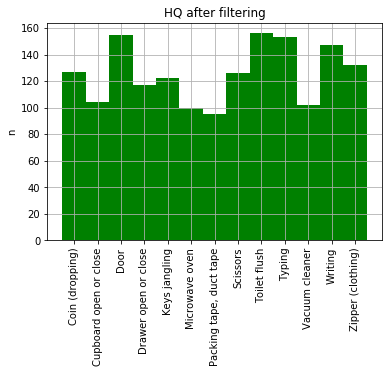

In [27]:
f = plt.figure(2)
plt.bar(dataset_90.keys(), dataset_90.values(), 1.0, color='g')
plt.title("HQ after filtering")
plt.xticks(rotation=90)
plt.ylabel("n")
plt.grid()
plt.savefig('hq_after_filter.png', bbox_inches='tight')

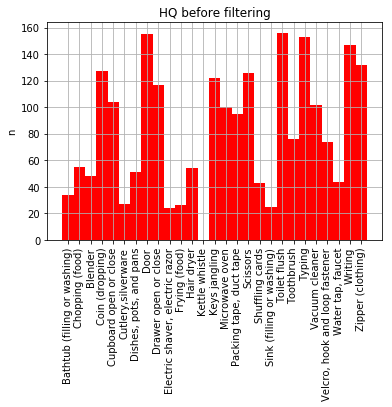

In [13]:
f = plt.figure(2)
plt.bar(dataset_len.keys(), dataset_len.values(), 1.0, color='r')
plt.title("HQ before filtering")
plt.xticks(rotation=90)
plt.ylabel("n")
plt.grid()
plt.savefig('hq_before_filter.png', bbox_inches='tight')

In [ ]:
dataset_with_candidates = dict()
for key,value in domestic_ids.items():
    dataset_with_candidates[value] = data_sounds[key]["PP"]

for key,value in domestic_ids.items():
    dataset_with_candidates[value] = data_sounds[key]["PNP"]

for key,value in domestic_ids.items():
    dataset_with_candidates[value] = data_sounds[key]["U"]

for key,value in domestic_ids.items():
    dataset_with_candidates[value] = data_sounds[key]["candidates"]

#with open('dataset_categories_with_candidates_nb.json', 'w') as fp:
#    json.dump(dataset_with_candidates, fp)

## Candidates (PNP + U + candidates)

In [ ]:
n_candidates = dict()

for i in domestic_ids:
    n_candidates[domestic_ids[i]] = len(data_sounds[i]['PNP']) + len(data_sounds[i]['U']) + len(data_sounds[i]['candidates'])

In [ ]:
candidates = dict()

for i in domestic_ids:
    candidates[domestic_ids[i]] = data_sounds[i]['PNP'] + data_sounds[i]['U'] + data_sounds[i]['candidates']

In [ ]:
candidates

In [ ]:
f = plt.figure(1)
plt.bar(n_candidates.keys(), n_candidates.values(), 1.0, color='r')
plt.title("candidates-per-category")
plt.xticks(rotation=90)
plt.ylabel("n")

In [ ]:
n_candidates_90 = dict()

for key,value in domestic_ids.items():
    if len(data_sounds[key]["PP"]) > 90:
        n_candidates_90[domestic_ids[key]] = len(data_sounds[key]['PNP']) + len(data_sounds[key]['U']) + len(data_sounds[key]['candidates'])
        print(domestic_ids[key] + ": " + str(len(data_sounds[key]['PNP']) + len(data_sounds[key]['U']) + len(data_sounds[key]['candidates'])))

In [ ]:
candidates_90 = dict()

for key,value in domestic_ids.items():
    if len(data_sounds[key]["PP"]) > 90:
        candidates_90[domestic_ids[key]] = data_sounds[key]['PNP'] + data_sounds[key]['U'] + data_sounds[key]['candidates']
        print(domestic_ids[key] + ": " + str(len(data_sounds[key]['PNP']) + len(data_sounds[key]['U']) + len(data_sounds[key]['candidates'])))

In [ ]:
#with open('../json_final/generated/candidates.json', 'w') as fp:
#    json.dump(candidates_90, fp)

In [ ]:
f = plt.figure(2)
plt.bar(n_candidates_90.keys(), n_candidates_90.values(), 1.0, color='r')
plt.title("candidates-per-category only HQ")
plt.xticks(rotation=90)
plt.ylabel("n")
plt.savefig('candidates_per_category.png', bbox_inches='tight')

In [ ]:
qe_categories = dict()
# for every category compute QE here number of votes len(PP) + len(PNP) / all
# QE should only be computed if there are more than MIN_VOTES_CAT votes. else not reliable
for i in domestic_ids:
    data_sounds[i]['QE'] = (len(data_sounds[i]['PP']) + len(data_sounds[i]['PNP'])) / float(
        len(data_sounds[i]['PP']) + len(data_sounds[i]['PNP']) + len(data_sounds[i]['NP']) + len(data_sounds[i]['U']))
    if len(data_sounds[i]["PP"]) > 90:
        qe_categories[domestic_ids[i]] = data_sounds[i]['QE']

In [ ]:
for i in domestic_ids:
    if len(data_sounds[i]["PP"]) > 90:
        print(domestic_ids[i] + ": " + str(qe_categories[domestic_ids[i]]))

In [ ]:
f = plt.figure(2)
plt.bar(qe_categories.keys(), qe_categories.values(), 1.0, color='g')
plt.title("QE per category")
plt.xticks(rotation=90)
plt.ylabel("n")
plt.savefig('qe.png', bbox_inches='tight')